```text
03.EDA_FinalizePreprocessing.ipynb
├── 1. Data Quality Checks
│   └── 1.1 Image Size Statistics & Aspect Ratio Analysis
│       └── Small Image Sizes & Extreme Aspect Ratios
├── 2. Contrast Enhancement

In [1]:
import sys
from pathlib import Path
DATA_ROOT = "../data/raw/archive"
project_root = Path.cwd().parent
sys.path.append(str(project_root))
from src.utils.eda_utils import *
df = collect_metadata( DATA_ROOT, cache_path="../data/eda/metadata.csv", refresh=True)
print("Total images:", len(df))
CLASS_ORDER =["normal", "pneumonia", "tuberculosis"] #df.label.value_counts().keys().tolist()
CLASS_COLORS = { "normal": "#83F87B",  "pneumonia": "#F7B986",  "tuberculosis": "#F78174"}
SPLITS = ["train", "val", "test"]
df.head()


Metadata saved to ../data/eda/metadata.csv
Total images: 25553


,path,filename,split,label
0,../data/raw/archive/train/normal/normal-2125.jpg,normal-2125.jpg,train,normal
1,../data/raw/archive/train/normal/normal-4554.jpg,normal-4554.jpg,train,normal
2,../data/raw/archive/train/normal/normal-5892.jpg,normal-5892.jpg,train,normal
3,../data/raw/archive/train/normal/normal-6343.jpg,normal-6343.jpg,train,normal
4,../data/raw/archive/train/normal/normal-6425.jpg,normal-6425.jpg,train,normal


### 1. Data Quality Check

In [4]:
### 1.1 Image Size Statistics & Aspect Ratio Analysis
size_df = compute_size_flags(df, max_samples=df.shape[0]) 
plot_size_distributions(size_df, CLASS_ORDER, save_path="image_resolution_distribution.png")
plot_aspect_ratio_distribution(size_df, CLASS_COLORS, classorder=CLASS_ORDER, save_path="aspect_ratio_distribution.png")

100%|██████████| 25553/25553 [00:03<00:00, 6880.57it/s]


Aspect ratio analysis shows that most images are near-square (AR ≈ 1), with pneumonia images exhibiting slightly greater variability and extreme aspect ratios (AR > 2) occurring rarely across all classes.

In [22]:
(size_df.groupby("label")[["small_image", "extreme_aspect_ratio"]].mean().mul(100).round(2).style.format("{:.2f}").set_caption("Image Size Statistics by Label"))

,small_image,extreme_aspect_ratio
label,,
normal,0.00,0.02
pneumonia,0.70,2.16
tuberculosis,18.84,0.01


Black border removal had no adverse impact on image geometry. 
Changes are minimal, class-consistent, and limited to revealing the true effective resolution of a small subset of Tuberculosis images. 
This validates that the border removal procedure is safe, and that geometry-related preprocessing decisions remain unchanged.

### 2. Contrast Enhancement

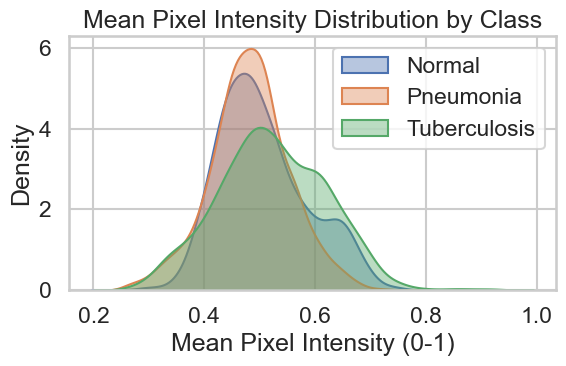

In [10]:
# 2.1 Intensity / pixel Per-class (Density plot)
plot_intensity_distribution_by_class(df, CLASS_ORDER)

In [23]:
# 2.2 Statistically under/over -exposed
#Flag outliers by Saturation Fractions & Robust Z-Scores
from src.utils.image_utils import exposure_metrics, robust_z
exp = exposure_metrics(df, max_samples=df.shape[0]) # Exposure metrics calculation
# Severe exposure failure (QC)
exp["severe_under"] = (exp.black_frac > 0.40) | (exp.p99 < 0.50)
exp["severe_over"] = (exp.white_frac > 0.40) | (exp.p01 > 0.45)
# Low contrast (CLAHE)
exp["dynamic_range"] = exp.p99 - exp.p01
exp["z_std"] = robust_z(exp["std"].values)
exp["low_contrast"] = (exp.dynamic_range < 0.35) | (exp.z_std < -2.5)
exp["apply_clahe"] = exp["low_contrast"] & ~exp["severe_under"] & ~exp["severe_over"]
summary = exp[["severe_under", "severe_over", "low_contrast", "apply_clahe"]].mean().mul(100).round(2)
print(summary)
exp.to_csv("exposure_metrics_afterborder_removal.csv", index=False)

severe_under    0.03
severe_over     0.67
low_contrast    1.68
apply_clahe     1.29
dtype: float64


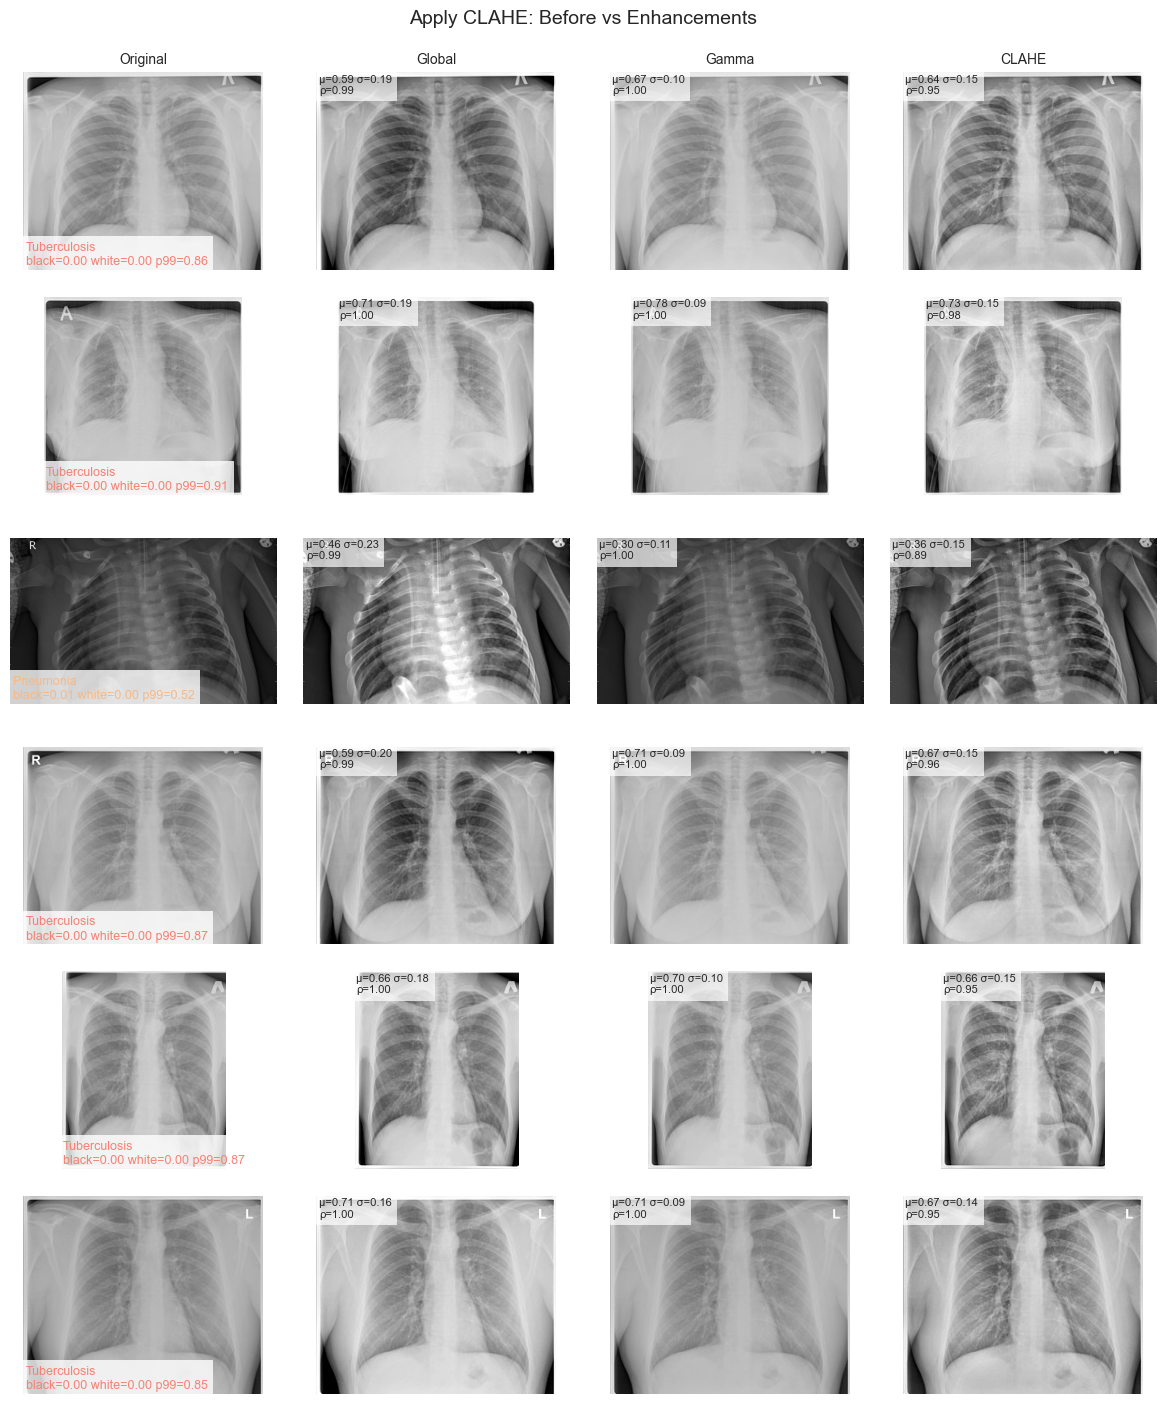

In [31]:
visualize_exposure_set(exp[exp["apply_clahe"]].sample(6, random_state=42), "Apply CLAHE: Before vs Enhancements" , CLASS_COLORS)

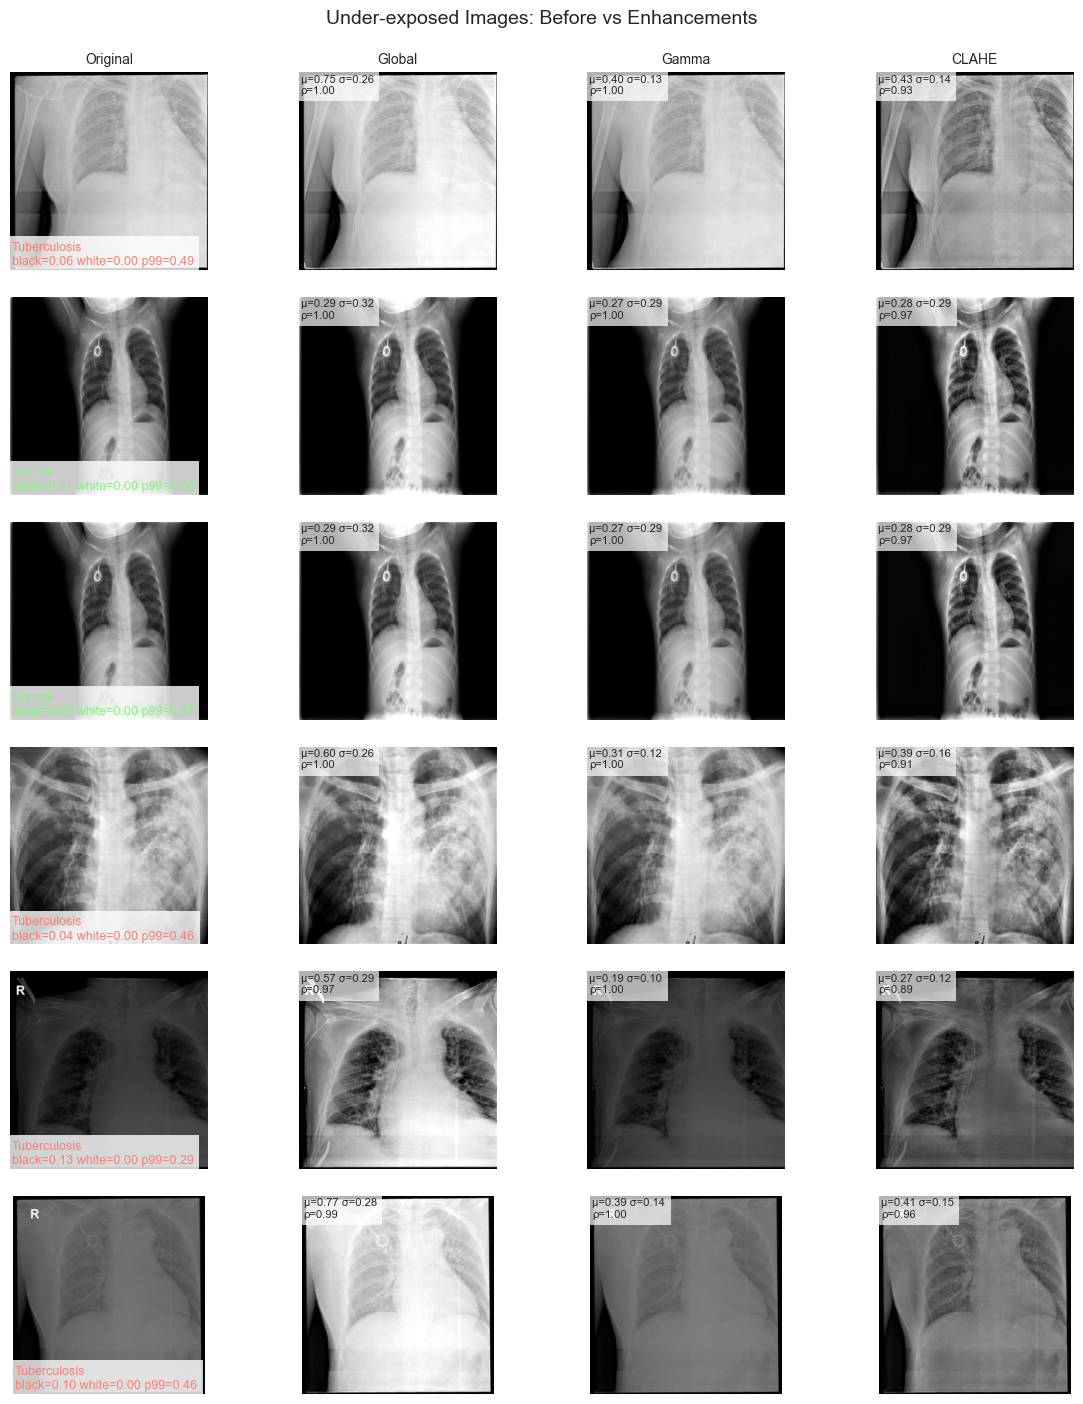

In [ ]:
visualize_exposure_set(exp[exp["severe_under"]].sample(6, random_state=42), "Severe Under-exposed: Before vs Enhancements" , CLASS_COLORS)

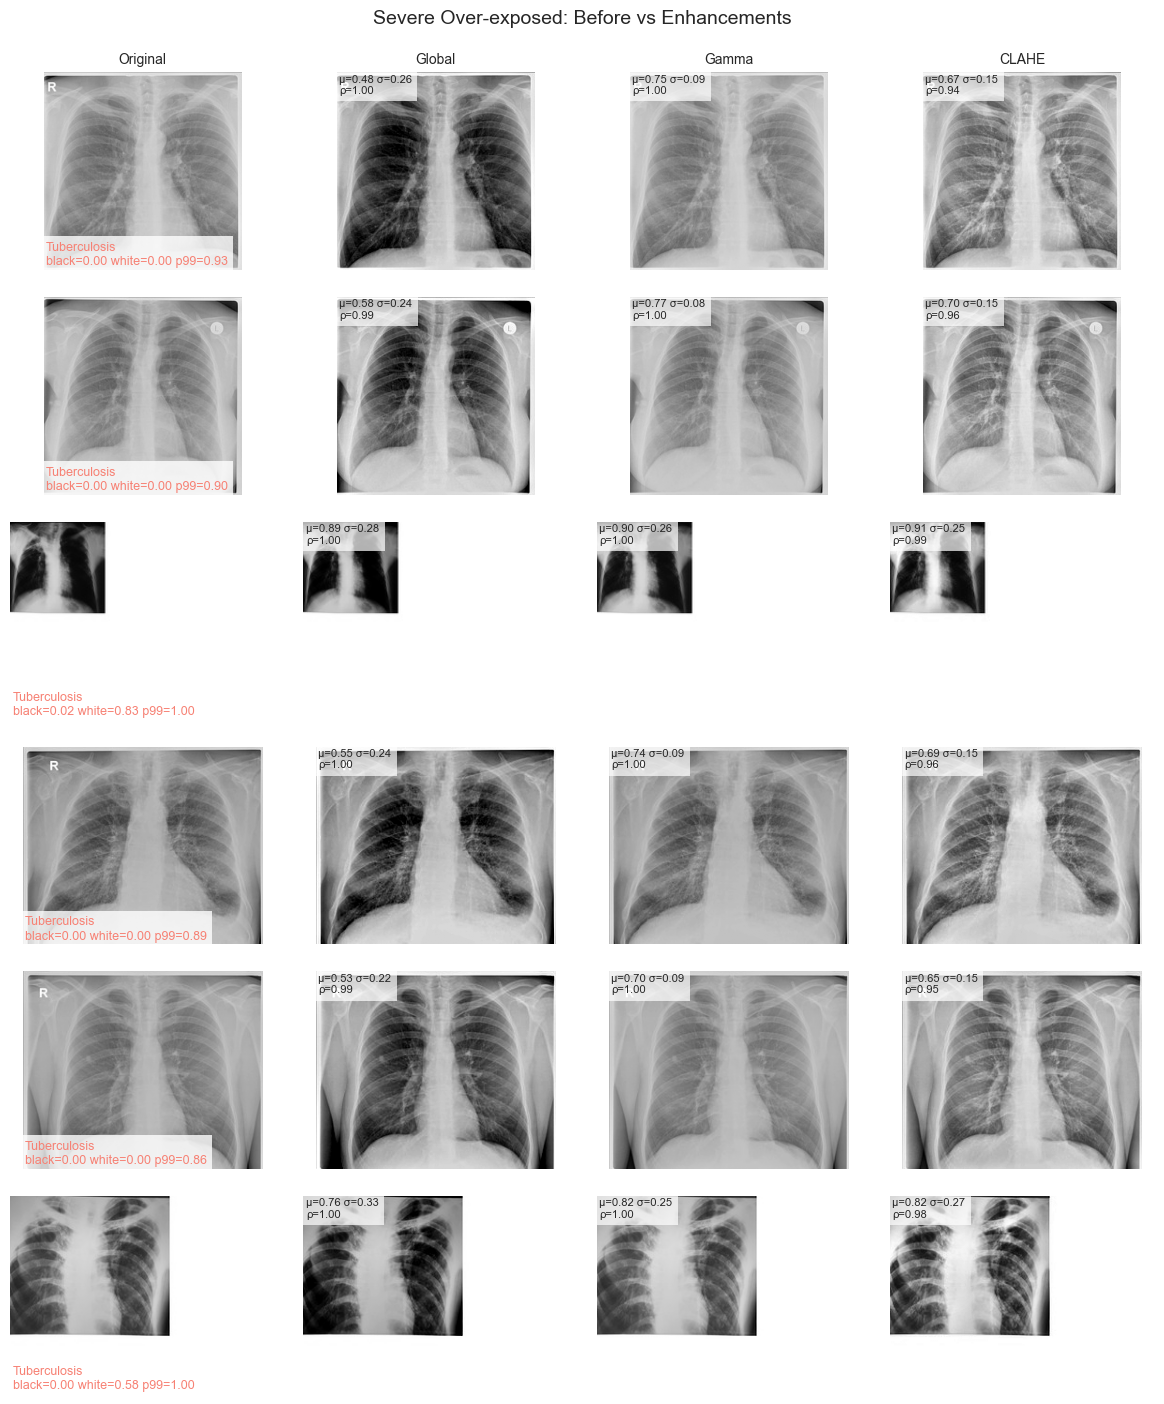

In [30]:
visualize_exposure_set(exp[exp["severe_over"]].sample(6, random_state=42), "Severe Over-exposed: Before vs Enhancements" , CLASS_COLORS)

Findings

Images with very low p99 or very high p01 indicate that nearly the entire image lies in a narrow dark or bright range, making them fundamentally degraded rather than just low-contrast. 
Applying CLAHE to such images could amplify noise, artifacts, or background, potentially harming model learning. 
As a result, these images are flagged for reporting and excluded from enhancement. 
CLAHE is only applied when the image exhibits low contrast without being severely under- or over-exposed.

After black border removal, severe exposure failures are rare, and conditional CLAHE is applied to approximately 1.3% of images, targeting only statistically justified low-contrast cases.

In [16]:
import cv2
p = "/Users/lily/Documents/Projects/chest-xray/data/raw/archive/train/pneumonia/pneumonia-2796.jpg"
# /Users/lily/Documents/Projects/chest-xray/data/raw/archive/test/tuberculosis/tuberculosis-901.jpg
p= '/Users/lily/Documents/Projects/chest-xray/data/raw/archive/test/tuberculosis/tuberculosis-901.jpg'
image = cv2.imread( p , cv2.IMREAD_GRAYSCALE)
image1 = cv2.imread(p)


In [17]:
image1.shape

(303, 492, 3)

In [18]:
import numpy as np
c0 = image1[:, :, 0]
c1 = image1[:, :, 1]
c2 = image1[:, :, 2]
same_01 = np.array_equal(c0, c1)
same_02 = np.array_equal(c0, c2)
same_12 = np.array_equal(c1, c2)
print(same_01, same_02, same_12)


True True True


Conclusion:
At the end of EDA, we will perform 
- Horizontal Flip 
- Blackborder Removal
- Contrast Enhancement (CLHAE)
- Random rotation (±10 degrees)
- Horizontal/Vertical shift(0.2)
- Random zoom in/out (0.2)
- GaussianBlur
- ColorJitter (brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
- Fill_mode (nearest)